In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk")

<h3>1. How many tennis players are included in the dataset?</h3>

In [26]:
columns_to_select = ['match_id', 'player_id']
match_home_df = pd.read_parquet('../data/raw/parquets/match_home_team.parquet', engine='pyarrow', columns=columns_to_select)
match_away_team_df = pd.read_parquet('../data/raw/parquets/match_away_team.parquet', engine='pyarrow', columns=columns_to_select)

In [27]:
print(match_home_df.head(), '\n')
print(match_away_team_df.head())

   match_id  player_id
0  11998445     287803
1  11998446      62790
2  11998447      64580
3  11998448     131442
4  11998449      22218 

   match_id  player_id
0  11998445     192013
1  11998446     273680
2  11998447      77223
3  11998448      88992
4  11998449     248846


In [28]:
print('match_home shape:', match_home_df.shape)
print('match_away shape:', match_away_team_df.shape)

match_home shape: (12389, 2)
match_away shape: (11690, 2)


In [29]:
concat_df = pd.concat([match_home_df, match_away_team_df])

In [30]:
print('Number of duplicates:', concat_df.duplicated().sum())
print('player_id nulls:', concat_df['player_id'].isnull().sum())

Number of duplicates: 0
player_id nulls: 0


In [31]:
print('Number of unique players:', concat_df['player_id'].nunique())

Number of unique players: 2644


In [32]:
del match_home_df, match_away_team_df, concat_df

<h3>2. What is the average height of the players? </h3>

In [33]:
df_home = pd.read_parquet('../data/raw/parquets/match_home_team.parquet',
                          columns=['player_id', 'height'])


df_away = pd.read_parquet('../data/raw/parquets/match_away_team.parquet',
                          columns=['player_id', 'height'])


df_all = pd.concat([df_home, df_away], ignore_index=True)


df_unique = df_all.drop_duplicates(subset='player_id')


average_height = df_unique['height'].dropna().mean()

print("Average height of all unique players:", round(average_height, 2), "cm")
print("Total unique players counted:", len(df_unique))


Average height of all unique players: 1.82 cm
Total unique players counted: 2644


<h3>3. Which player has the highest number of wins? </h3>

In [34]:
match_event = pd.read_parquet('../data/raw/parquets/match_event.parquet')
home_team = pd.read_parquet('../data/raw/parquets/match_home_team.parquet')
away_team = pd.read_parquet('../data/raw/parquets/match_away_team.parquet')


home_wins = match_event[match_event['winner_code'] == 1].merge(
    home_team[['match_id', 'player_id', 'full_name']],
    on='match_id',
    how='left'
)

away_wins = match_event[match_event['winner_code'] == 2].merge(
    away_team[['match_id', 'player_id', 'full_name']],
    on='match_id',
    how='left'
)


all_wins = pd.concat([home_wins[['player_id','full_name']], away_wins[['player_id','full_name']]])
win_counts = all_wins.groupby(['player_id','full_name']).size().reset_index(name='wins')


top_player = win_counts.sort_values('wins', ascending=False).head(1)
print(top_player)

     player_id      full_name  wins
186    50901.0  Popko, Dmitry    30


<h3>4. What is the longest match recorded in terms of duration?</h3>

In [35]:
df = pd.read_parquet("../data/raw/parquets/match_time.parquet")


period_cols = ['period_1', 'period_2', 'period_3', 'period_4', 'period_5']

df['total_duration'] = df[period_cols].sum(axis=1, skipna=True)


longest_match = df.loc[df['total_duration'].idxmax()]


print(" Longest match recorded:")
print(f"Match ID: {longest_match['match_id']}")
print(f"Total Duration: {longest_match['total_duration']} (units depend on dataset — likely seconds or minutes)")



FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/parquets/match_time.parquet'

<h3>5. How many sets are typically played in a tennis match? </h3>

In [15]:
df = pd.read_parquet("../data/raw/parquets/statistics_statistics.parquet")


df = df.dropna(subset=["period"])


sets_per_match = df.groupby("match_id")["period"].nunique()


average_sets = sets_per_match.mean()
average_sets = np.round(average_sets)

print(f"Average number of sets typically played in a tennis match: {average_sets:.2f}")

Average number of sets typically played in a tennis match: 3.00


<h3>6. Which country has produced the most successful tennis players? </h3>

In [16]:
match_event = pd.read_parquet('../data/raw/parquets/match_event.parquet')
home_team = pd.read_parquet('../data/raw/parquets/match_home_team.parquet')
away_team = pd.read_parquet('../data/raw/parquets/match_away_team.parquet')


home_wins = match_event[match_event['winner_code'] == 1].merge(
    home_team[['match_id', 'player_id', 'country']],
    on='match_id',
    how='left'
)


away_wins = match_event[match_event['winner_code'] == 2].merge(
    away_team[['match_id', 'player_id', 'country']],
    on='match_id',
    how='left'
)


all_wins = pd.concat([home_wins[['country']], away_wins[['country']]])


country_wins = all_wins.groupby('country').size().reset_index(name='wins')


top_country = country_wins.sort_values('wins', ascending=False).head(1)
print(top_country)


   country  wins
29  France   659


<h3>7. What is the average number of aces per match? </h3>

In [17]:
df = pd.read_parquet("../data/raw/parquets/statistics_statistics.parquet")


df_aces = df[df["statistic_name"] == "aces"]


aces_per_match = df_aces.groupby("match_id")[["home_value", "away_value"]].sum().sum(axis=1)

average_aces = aces_per_match.mean()
average_aces = np.round(average_aces)

print(f"Average number of aces per match: {average_aces:.2f}")


Average number of aces per match: 11.00


<h3>8. Is there a difference in the number of double faults based on gender?</h3>

In [18]:
columns_to_select = ['match_id', 'gender']
statistics_df = pd.read_parquet('../data/raw/parquets/statistics_statistics.parquet', columns=['match_id', 'statistic_name'])
match_away_df = pd.read_parquet('../data/raw/parquets/match_away_team.parquet', columns=columns_to_select)
match_home_df = pd.read_parquet('../data/raw/parquets/match_home_team.parquet', columns=columns_to_select)

In [10]:
statistics_df.head()

,match_id,statistic_name
0,11998445,aces
1,11998445,double_faults
2,11998445,first_serve
3,11998445,second_serve
4,11998445,first_serve_points


In [11]:
statistics_df.shape

(665589, 2)

In [12]:
concat_home_away_df = pd.concat([match_away_df, match_home_df])
concat_home_away_df.head()

,match_id,gender
0,11998445,M
1,11998446,M
2,11998447,M
3,11998448,M
4,11998449,M


In [13]:
statistics_df_filtered = statistics_df.loc[
    statistics_df['statistic_name'] == 'double_faults'
]

In [14]:
stats_matches_merged = pd.merge(statistics_df_filtered, concat_home_away_df, how='inner', on='match_id')

In [15]:
double_fault_dist_gender_df = stats_matches_merged['gender'].value_counts().reset_index()
double_fault_dist_gender_df['gender'] = double_fault_dist_gender_df['gender'].map({'M': 'Male', 'F': 'Female'})
double_fault_dist_gender_df

,gender,count
0,Male,36761
1,Female,28526


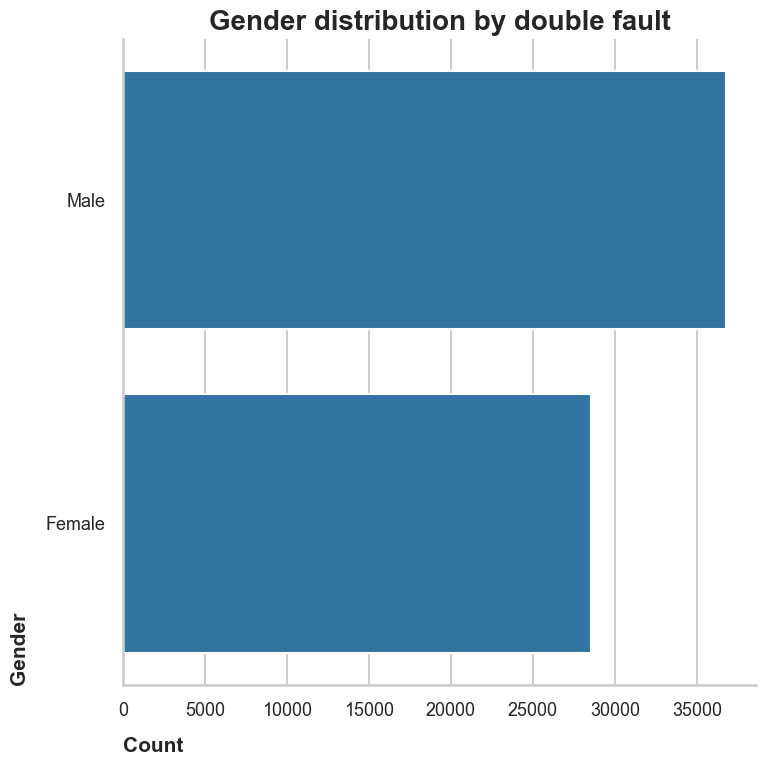

In [16]:
plt.figure(figsize=(8, 8))
sns.barplot(double_fault_dist_gender_df, x='count', y='gender')
plt.title(f'Gender distribution by double fault', fontweight='bold', fontsize=20)
plt.xlabel('Count', fontsize=15, fontweight='bold', loc='left', labelpad=12)
plt.ylabel('Gender', fontsize=15, fontweight='bold', loc='bottom', labelpad=12)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
sns.despine()
plt.tight_layout()
plt.show()

In [17]:
del statistics_df, match_away_df, match_home_df, concat_home_away_df\
    ,statistics_df_filtered, double_fault_dist_gender_df, stats_matches_merged

<h3>9. Which player has won the most tournaments in a single month?</h3>

In [18]:
columns_to_select = ['match_id', 'full_name']
match_event_df = pd.read_parquet('../data/raw/parquets/match_event.parquet', columns=['match_id', 'start_datetime', 'winner_code'])
match_home_df = pd.read_parquet('../data/raw/parquets/match_home_team.parquet', columns=columns_to_select)
match_away_df = pd.read_parquet('../data/raw/parquets/match_away_team.parquet', columns=columns_to_select)

In [19]:
match_event_df.head()

,match_id,start_datetime,winner_code
0,11974049,1707051600,2.0
1,11974052,1706882400,2.0
2,11974053,1706878800,1.0
3,11974065,1707055200,1.0
4,11974066,1706871600,2.0


In [20]:
match_event_df.shape

(16873, 3)

In [21]:
match_event_df['start_datetime_transformed'] = pd.to_datetime(match_event_df['start_datetime'], unit='s')
match_event_df['start_datetime_transformed'].head()

0   2024-02-04 13:00:00
1   2024-02-02 14:00:00
2   2024-02-02 13:00:00
3   2024-02-04 14:00:00
4   2024-02-02 11:00:00
Name: start_datetime_transformed, dtype: datetime64[ns]

In [22]:
match_event_df['month'] = match_event_df['start_datetime_transformed'].dt.month
match_event_df[(match_event_df['month'] == 4) | (match_event_df['month'] == 1)] = np.nan

In [23]:
match_event_df.isna().sum()

match_id                      347
start_datetime                347
winner_code                   941
start_datetime_transformed    347
month                         347
dtype: int64

In [24]:
match_event_df.dropna(inplace=True)

In [25]:
match_event_df.describe()

,match_id,start_datetime,winner_code,start_datetime_transformed,month
count,1.593200e+04,1.593200e+04,15932.000000,15932,15932.000000
mean,1.211911e+07,1.709445e+09,1.483367,2024-03-03 05:50:27.665076480,2.553038
min,1.197405e+07,1.706746e+09,1.000000,2024-02-01 00:05:00,2.000000
25%,1.207772e+07,1.708306e+09,1.000000,2024-02-19 01:18:45,2.000000
50%,1.212215e+07,1.709545e+09,1.000000,2024-03-04 09:30:00,3.000000
75%,1.216478e+07,1.710666e+09,2.000000,2024-03-17 08:55:00,3.000000
max,1.221139e+07,1.711922e+09,2.000000,2024-03-31 22:00:00,3.000000
std,5.113934e+04,1.408561e+06,0.499739,NaN,0.497195


In [26]:
match_home_df.rename(columns={'full_name': 'full_name_home'}, inplace=True)
match_away_df.rename(columns={'full_name': 'full_name_away'}, inplace=True)

print(match_home_df.columns.tolist())
print(match_away_df.columns.tolist())

['match_id', 'full_name_home']
['match_id', 'full_name_away']


In [27]:
home_away_merged = pd.merge(match_home_df, match_away_df, how='inner', on='match_id')
home_away_merged.head()

,match_id,full_name_home,full_name_away
0,11998445,"Cazaux, Arthur","Auger-Aliassime, Felix"
1,11998446,"Lestienne, Constant",Flavio Cobolli
2,11998447,"Ćorić, Borna","Martinez, Pedro"
3,11998448,"Mmoh, Michael","Muller, Alexandre"
4,11998449,"Paire, Benoit","Mayot, Harold"


In [28]:
home_away_merged.isnull().sum()

match_id          0
full_name_home    0
full_name_away    0
dtype: int64

In [29]:
print('Number of duplicated match_id', home_away_merged['match_id'].duplicated().sum())

Number of duplicated match_id 0


In [30]:
home_away_event_merged_df = pd.merge(home_away_merged, match_event_df.drop(columns=['start_datetime', 'start_datetime_transformed']), 
                                     on='match_id', how='inner')
home_away_event_merged_df = home_away_event_merged_df.sort_values(by=['month'], ascending=False)
print(home_away_event_merged_df.head())

      match_id       full_name_home  full_name_away  winner_code  month
9446  12211394    Martineau, Matteo  Miedler, Lucas          2.0    3.0
9445  12210911      Yevseyev, Denis      Wu, Yibing          2.0    3.0
9444  12210890       Statham, Rubin  Chappell, Nick          2.0    3.0
9443  12210889  Trotter, James Kent       Zhu, Evan          1.0    3.0
9404  12210279   Shymanovich, Iryna    Tan, Harmony          1.0    3.0


In [31]:
home_away_event_merged_df.isnull().sum()

match_id          0
full_name_home    0
full_name_away    0
winner_code       0
month             0
dtype: int64

In [32]:
home_away_event_merged_df['winner_full_name'] = np.where(
    home_away_event_merged_df['winner_code'] == 1, 
    home_away_event_merged_df['full_name_home'],
    home_away_event_merged_df['full_name_away']
)

home_away_event_merged_df['winner_full_name'].head()

9446         Miedler, Lucas
9445             Wu, Yibing
9444         Chappell, Nick
9443    Trotter, James Kent
9404     Shymanovich, Iryna
Name: winner_full_name, dtype: object

In [33]:
wins_per_month = (
    home_away_event_merged_df.groupby(['month', 'winner_full_name']).size()
    .reset_index(name='num_wins')
)

top_winners = (
    wins_per_month.loc[wins_per_month.groupby('month')['num_wins'].idxmax()]
    .sort_values('month')
)
top_winners['month'] = top_winners['month'].map({2: 'February', 3: 'March'})

top_winners.head()

,month,winner_full_name,num_wins
1064,February,"Popko, Dmitry",15
1949,March,"Faria, Jaime",15


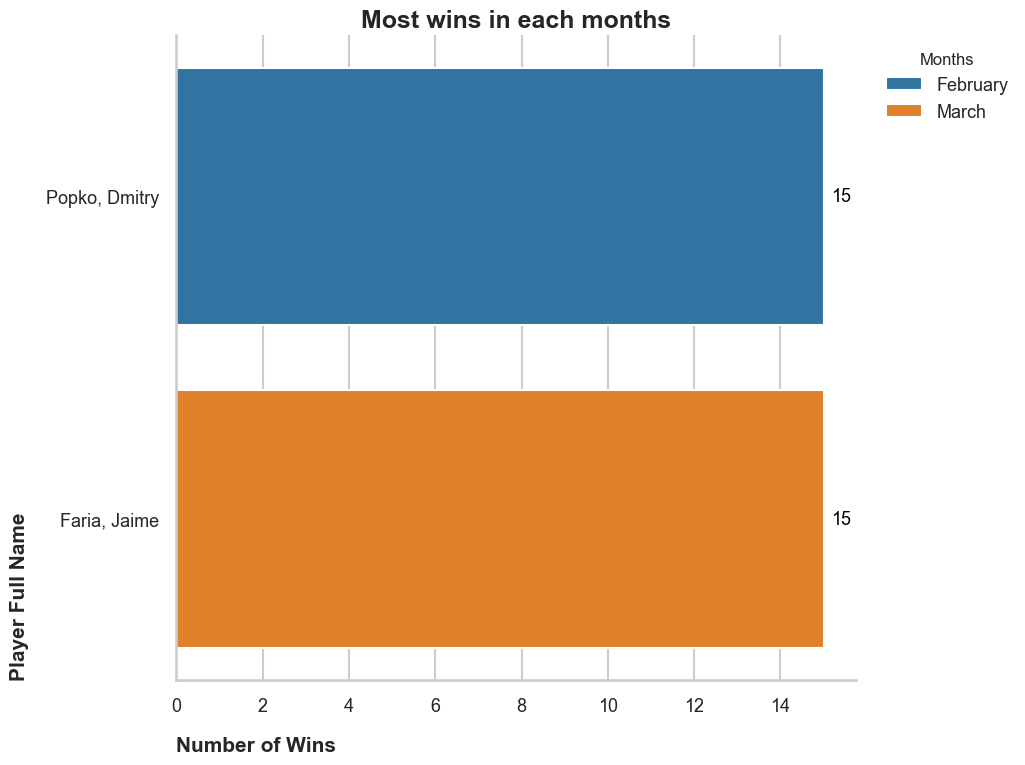

In [34]:
plt.figure(figsize=(9, 8))
ax = sns.barplot(top_winners, x='num_wins', y='winner_full_name', hue='month')

for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.annotate(f'{width:.0f}',
                    (width, p.get_y() + p.get_height() / 2),
                    ha='left', va='center',
                    fontsize=13, color='black',
                    xytext=(5, 0), textcoords='offset points')

plt.title(f'Most wins in each months', fontweight='bold', fontsize=18)
plt.xlabel('Number of Wins', fontsize=15, fontweight='bold', loc='left', labelpad=15)
plt.ylabel('Player Full Name', fontsize=15, fontweight='bold', loc='bottom', labelpad=12)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
sns.despine()
plt.tight_layout()
plt.legend(
    title='Months',
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    frameon=False,
    fontsize=13,
    title_fontsize=12
)
plt.show()

In [35]:
del match_home_df, match_event_df, home_away_event_merged_df, home_away_merged,\
    wins_per_month, top_winners

<h3>10. Is there a correlation between a player's height and their ranking?</h3>

In [36]:
columns_to_select = ['player_id', 'height', 'current_rank']
match_home_df = pd.read_parquet('../data/raw/parquets/match_home_team.parquet', engine='pyarrow', columns=columns_to_select)
match_away_team_df = pd.read_parquet('../data/raw/parquets/match_away_team.parquet', engine='pyarrow', columns=columns_to_select)

In [37]:
print(match_away_team_df.shape)
print(match_home_df.shape)

(11690, 3)
(12389, 3)


In [38]:
match_home_new_cols_name = [f'{col}_match_home' if col != 'player_id' else 'player_id' for col in match_home_df.columns]
match_away_new_cols_name = [f'{col}_match_away' if col != 'player_id' else 'player_id' for col in match_away_team_df.columns]

match_home_df.rename(columns=dict(zip(match_home_df.columns, match_home_new_cols_name)), inplace=True)
match_away_team_df.rename(columns=dict(zip(match_away_team_df.columns, match_away_new_cols_name)), inplace=True)

In [39]:
print(match_home_df.columns)
print(match_away_team_df.columns)

Index(['player_id', 'height_match_home', 'current_rank_match_home'], dtype='object')
Index(['player_id', 'height_match_away', 'current_rank_match_away'], dtype='object')


In [40]:
df_merged = pd.merge(match_home_df, match_away_team_df, how='inner', on='player_id')

In [41]:
df_merged.head()

,player_id,height_match_home,current_rank_match_home,height_match_away,current_rank_match_away
0,287803,1.83,86.0,1.83,86.0
1,287803,1.83,86.0,1.83,83.0
2,287803,1.83,86.0,1.83,86.0
3,62790,1.80,99.0,1.80,99.0
4,62790,1.80,99.0,1.80,104.0


In [42]:
df_merged.shape

(63492, 5)

In [43]:
print('Number of duplicates:', df_merged.duplicated().sum())

Number of duplicates: 44084


In [44]:
df_merged.isnull().sum()

player_id                      0
height_match_home          25027
current_rank_match_home      373
height_match_away          25023
current_rank_match_away      389
dtype: int64

In [45]:
df_merged['height_match_home'] = df_merged['height_match_home'].fillna(df_merged['height_match_away'])
df_merged['height_match_away'] = df_merged['height_match_away'].fillna(df_merged['height_match_home'])

In [46]:
df_merged.isnull().sum()

player_id                      0
height_match_home          24899
current_rank_match_home      373
height_match_away          24899
current_rank_match_away      389
dtype: int64

In [47]:
df_merged = df_merged[['player_id', 'height_match_home', 'current_rank_match_away']]
df_merged.columns = ['player_id', 'height', 'current_rank']
df_merged.drop_duplicates(inplace=True)
df_merged.dropna(inplace=True)

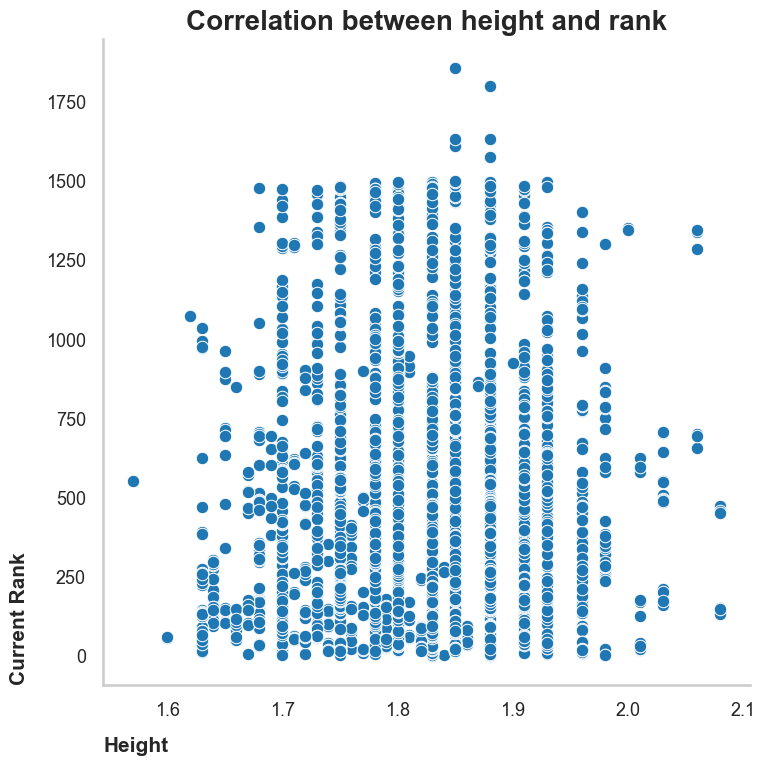

In [48]:
plt.figure(figsize=(8, 8))
sns.scatterplot(df_merged, x='height', y='current_rank')
plt.title(f'Correlation between height and rank', fontweight='bold', fontsize=20)
plt.xlabel('Height', fontsize=15, fontweight='bold', loc='left', labelpad=12)
plt.ylabel('Current Rank', fontsize=15, fontweight='bold', loc='bottom', labelpad=12)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
sns.despine()
plt.grid()
plt.tight_layout()
plt.show()

In [49]:
del match_home_df, match_away_team_df, df_merged

<h3>11. What is the average duration of matches?</h3>

In [50]:
time_df = pd.read_parquet('../data/raw/parquets/match_time.parquet', columns=['match_id', 'period_1', 'period_2', 'period_3', 'period_4', 'period_5'])
time_df.head()

,match_id,period_1,period_2,period_3,period_4,period_5
0,11974049,NaN,NaN,NaN,None,None
1,11974052,NaN,NaN,NaN,None,None
2,11974053,NaN,NaN,NaN,None,None
3,11974065,NaN,NaN,NaN,None,None
4,11974066,NaN,NaN,NaN,None,None


In [51]:
time_df.shape

(16873, 6)

In [52]:
print('Number of duplicates:', time_df.duplicated().sum())

Number of duplicates: 0


In [53]:
time_df.isnull().mean()

match_id    0.000000
period_1    0.342796
period_2    0.343863
period_3    0.799028
period_4    1.000000
period_5    1.000000
dtype: float64

In [54]:
time_df.drop(columns=['match_id', 'period_4', 'period_5'], inplace=True, errors='ignore')

In [55]:
time_df.describe()

,period_1,period_2,period_3
count,11089.000000,11071.000000,3391.000000
mean,2866.858418,3084.054738,3175.481569
std,4888.519816,5141.821530,6262.163425
min,2.000000,-16200.000000,0.000000
25%,2043.000000,2116.000000,1957.500000
50%,2515.000000,2606.000000,2602.000000
75%,3149.000000,3255.000000,3292.000000
max,172606.000000,169438.000000,152072.000000


In [56]:
time_df[(time_df < 1200) | (time_df > 4500)] = np.nan
time_df.dropna(subset=['period_1'], inplace=True)
time_df.isnull().mean()

period_1    0.000000
period_2    0.057745
period_3    0.749173
dtype: float64

In [57]:
time_df['period_2'] = time_df['period_2'].fillna(time_df['period_2'].median())
print('period_2 null values:', time_df['period_2'].isnull().sum())

period_2 null values: 0


In [58]:
time_df['period_2'].describe()

count    10581.000000
mean      2660.522257
std        704.344321
min       1201.000000
25%       2148.000000
50%       2571.000000
75%       3101.000000
max       4498.000000
Name: period_2, dtype: float64

In [59]:
time_df['match_duration(s)'] = time_df.apply(lambda row: np.nansum(row), axis=1)
time_df['match_duration(s)']

12       10100.0
13        4863.0
14        5654.0
15        5729.0
16        4208.0
          ...   
16866     5367.0
16867     5552.0
16869     6904.0
16871     5665.0
16872     5773.0
Name: match_duration(s), Length: 10581, dtype: float64

In [60]:
time_df.loc[time_df['match_duration(s)'] > 25000, 'match_duration(s)'] = np.nan
print('match_duration null values:', time_df['match_duration(s)'].isnull().sum())

match_duration null values: 0


In [61]:
matches_duration_avg = time_df['match_duration(s)'].mean()
matches_duration_avg_min = np.round(matches_duration_avg / 60)
print('Average Match Duration (minutes)', matches_duration_avg_min)

Average Match Duration (minutes) 99.0


In [62]:
del time_df

<h3>12. What is the average number of games per set in men's matches compared to women's 
matches? </h3>

In [63]:
columns_to_select = ['match_id', 'gender']
power_df = pd.read_parquet('../data/raw/parquets/tennis_power_power.parquet', columns=['match_id', 'set_num', 'game_num'])
match_away_df = pd.read_parquet('../data/raw/parquets/match_away_team.parquet', columns=columns_to_select)
match_home_df = pd.read_parquet('../data/raw/parquets/match_home_team.parquet', columns=columns_to_select)

In [64]:
power_df.head()

,match_id,set_num,game_num
0,11998445,1,1
1,11998445,1,2
2,11998445,1,3
3,11998445,1,4
4,11998445,1,5


In [65]:
power_df.shape

(230581, 3)

In [66]:
power_df[['set_num', 'game_num']].describe()

,set_num,game_num
count,230581.000000,230581.000000
mean,1.670337,5.330045
std,0.675665,3.027710
min,1.000000,1.000000
25%,1.000000,3.000000
50%,2.000000,5.000000
75%,2.000000,8.000000
max,3.000000,13.000000


In [67]:
home_away_concat_df = pd.concat([match_away_df, match_home_df])
home_away_concat_df.drop_duplicates(subset=['match_id'], inplace=True)
home_away_concat_df.head()

,match_id,gender
0,11998445,M
1,11998446,M
2,11998447,M
3,11998448,M
4,11998449,M


In [68]:
power_concat_merged_df = pd.merge(power_df, home_away_concat_df, on='match_id', how="inner")
power_concat_merged_df.head()

,match_id,set_num,game_num,gender
0,11998445,1,1,M
1,11998445,1,2,M
2,11998445,1,3,M
3,11998445,1,4,M
4,11998445,1,5,M


In [69]:
power_concat_merged_df.shape

(221255, 4)

In [70]:
power_concat_merged_df.isnull().sum()

match_id      0
set_num       0
game_num      0
gender      379
dtype: int64

In [71]:
power_concat_merged_df['gender'] = power_concat_merged_df['gender'].fillna(power_concat_merged_df['gender'].mode()[0])

In [72]:
games_per_set = power_concat_merged_df.groupby(['gender'])['set_num'].mean().reset_index(name='avg_games')
games_per_set['gender'] = games_per_set['gender'].map({'M': 'Male', 'F': 'Female'})
games_per_set

,gender,avg_games
0,Female,1.670811
1,Male,1.677119


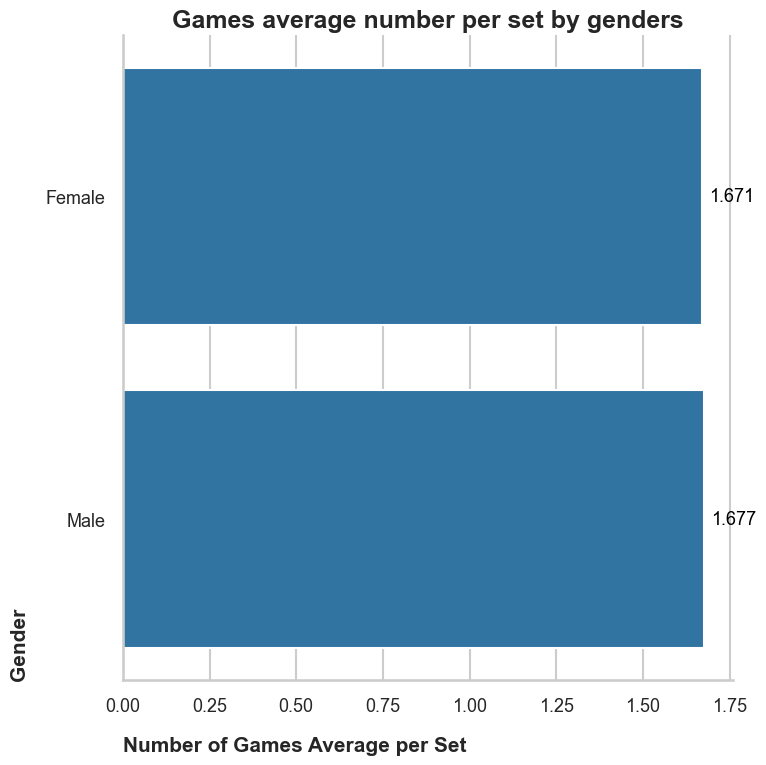

In [73]:
plt.figure(figsize=(8, 8))
ax = sns.barplot(games_per_set, x='avg_games', y='gender')

for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.annotate(f'{width:.3f}',
                    (width, p.get_y() + p.get_height() / 2),
                    ha='left', va='center',
                    fontsize=13, color='black',
                    xytext=(5, 0), textcoords='offset points')

plt.title(f'Games average number per set by genders', fontweight='bold', fontsize=18)
plt.xlabel('Number of Games Average per Set', fontsize=15, fontweight='bold', loc='left', labelpad=15)
plt.ylabel('Gender', fontsize=15, fontweight='bold', loc='bottom', labelpad=12)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
sns.despine()
plt.tight_layout()
plt.show()

In [74]:
del power_df, match_away_df, match_home_df, power_concat_merged_df, home_away_concat_df

<h3>13. What is the distribution of left-handed versus right-handed players? </h3>

In [4]:
df_away = pd.read_parquet('../data/raw/parquets/match_away_team.parquet', engine = 'pyarrow')
df_home = pd.read_parquet('../data/raw/parquets/match_home_team.parquet', engine = 'pyarrow')

df_away.head()

,match_id,name,slug,gender,user_count,residence,birthplace,height,weight,plays,turned_pro,current_prize,total_prize,player_id,current_rank,name_code,country,full_name
0,11998445,Auger-Aliassime F.,auger-aliassime-felix,M,23318,"Monte Carlo, Monaco","Montreal, Canada",1.93,87.0,right-handed,2017,218538.0,10166964.0,192013,30.0,AUG,Canada,"Auger-Aliassime, Felix"
1,11998446,Cobolli F.,flavio-cobolli,M,5960,Rome,"Florence, Italy",1.83,71.0,right-handed,None,171599.0,801778.0,273680,69.0,COB,Italy,Flavio Cobolli
2,11998447,Martínez P.,martinez-pedro,M,2621,"Valencia, Spain","Alzira, Spain",1.85,76.0,right-handed,2016,39448.0,2732689.0,77223,101.0,MAR,Spain,"Martinez, Pedro"
3,11998448,Muller A.,muller-alexandre,M,2443,France,"Poissy, France",1.83,73.0,right-handed,2014,106522.0,1178035.0,88992,81.0,MUL,France,"Muller, Alexandre"
4,11998449,Mayot H.,mayot-harold,M,1492,"Marly, France","Metz, France",1.78,78.0,right-handed,None,65798.0,424547.0,248846,132.0,MAY,France,"Mayot, Harold"


In [4]:
df_home.head()

,match_id,name,slug,gender,user_count,residence,birthplace,height,weight,plays,turned_pro,current_prize,total_prize,player_id,current_rank,name_code,country,full_name
0,11998445,Cazaux A.,cazaux-arthur,M,4481,None,"Montpellier, France",1.83,NaN,right-handed,None,233290.0,643582.0,287803,86.0,CAZ,France,"Cazaux, Arthur"
1,11998446,Lestienne C.,lestienne-constant,M,2034,"Paris, France","Amiens, France",1.80,72.0,right-handed,2012,98577.0,1397804.0,62790,99.0,LES,France,"Lestienne, Constant"
2,11998447,Ćorić B.,coric-borna,M,12414,"Dubai, UAE","Zagreb, Croatia",1.88,85.0,right-handed,2013,208593.0,9947986.0,64580,31.0,COR,Croatia,"Ćorić, Borna"
3,11998448,Mmoh M.,mmoh-michael,M,2206,"Bradenton, FL, USA","Riyadh, Saudi Arabia",1.88,90.0,right-handed,2016,47928.0,1775118.0,131442,122.0,MMO,USA,"Mmoh, Michael"
4,11998449,Paire B.,paire-benoit,M,6089,"Geneva, Switzerland","Avignon, France",1.96,80.0,right-handed,2007,33248.0,8622687.0,22218,110.0,PAI,France,"Paire, Benoit"


In [8]:
df_13 = pd.concat([
    df_away[['player_id', 'plays']],
    df_home[['player_id', 'plays']]
]).drop_duplicates()

In [9]:
df_13.head()

,player_id,plays
0,192013,right-handed
1,273680,right-handed
2,77223,right-handed
3,88992,right-handed
4,248846,right-handed


In [10]:
right_handed_count = list(df_13['plays']).count('right-handed')
left_handed_count = list(df_13['plays']).count('left-handed')

print(right_handed_count, left_handed_count)

1013 133


In [11]:
left_handed_percentage = (left_handed_count/(right_handed_count+left_handed_count))*100
print(left_handed_percentage)

11.605584642233858


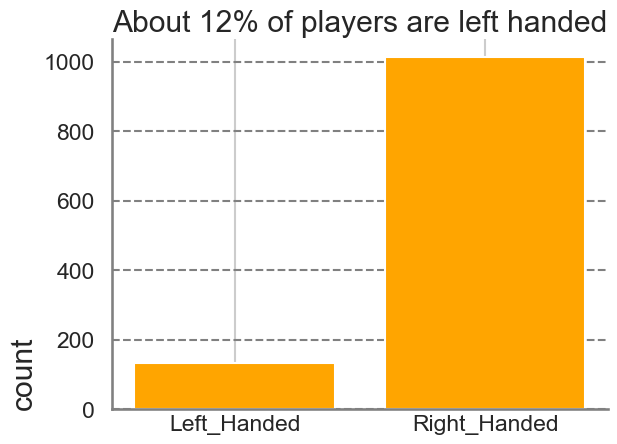

In [12]:
fig, ax = plt.subplots()
ax.bar(['Left_Handed', 'Right_Handed'], [left_handed_count, right_handed_count], color = 'orange')
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_color('gray')
ax.set_ylabel('count', loc = 'bottom', size = 'large')
ax.set_title('About 12% of players are left handed', size = 'large', loc = 'left')
ax.set_yticks(np.arange(0, 1100, 200))
ax.grid(axis = 'y', color = 'gray', linestyle = '--')
ax.tick_params(axis = 'x', length = 0)
ax.tick_params(color = 'gray')

<h3>14. What is the most common type of surface used in tournaments?</h3>

In [13]:
df_tournament = pd.read_parquet('../data/raw/parquets/match_tournament.parquet', engine = 'pyarrow')
df_tournament.head()

,match_id,tournament_id,tournament_name,tournament_slug,tournament_unique_id,tournament_category_name,tournament_category_slug,user_count,ground_type,tennis_points,has_event_player_statistics,crowd_sourcing_enabled,has_performance_graph_feature,display_inverse_home_away_teams,priority,competition_type
0,11974049,70826,Qualifiers,qualifiers,None,Davis Cup,davis-cup,6905,None,NaN,False,False,False,False,0,2.0
1,11974052,70826,Qualifiers,qualifiers,None,Davis Cup,davis-cup,6909,None,NaN,False,False,False,False,0,2.0
2,11974053,70826,Qualifiers,qualifiers,None,Davis Cup,davis-cup,6907,None,NaN,False,False,False,False,0,2.0
3,11974065,70826,Qualifiers,qualifiers,None,Davis Cup,davis-cup,6903,None,NaN,False,False,False,False,0,2.0
4,11974066,70826,Qualifiers,qualifiers,None,Davis Cup,davis-cup,6909,None,NaN,False,False,False,False,0,2.0


In [15]:
df_14 = df_tournament['ground_type'].value_counts().reset_index()
df_14

,ground_type,count
0,Hardcourt outdoor,8093
1,Red clay,5583
2,Hardcourt indoor,2188
3,Grass,267
4,Red clay indoor,236
5,Carpet indoor,126
6,Synthetic outdoor,114
7,Green clay,18


Text(0.0, 1.0, 'Hardcourt outdoor is the most common type of ground')

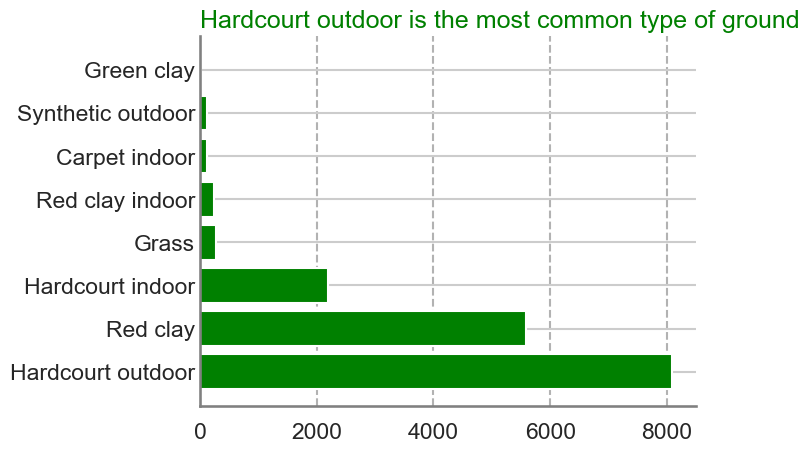

In [16]:
fig, ax = plt.subplots()
ax.barh(df_14['ground_type'], df_14['count'], color = 'green')

ax.tick_params(axis = 'y', length = 0)
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['left', 'bottom']].set_color('gray')
ax.grid(axis = 'x', color = 'gray', linestyle = '--', alpha = 0.6)
ax.set_title('Hardcourt outdoor is the most common type of ground', color = 'green', loc = 'left')

<h3>15. How many distinct countries are represented in the dataset? </h3>

In [17]:
df_venue = pd.read_parquet('../data/raw/parquets/match_venue.parquet', engine = 'pyarrow')
df_venue.head()

,match_id,city,stadium,venue_id,country
0,11974049,Varazdin,Varazdin Arena,6310,Croatia
1,11974052,Kraljevo,Sport Hall Ibar,31876,Serbia
2,11974053,Groningen,Martini Plaza,7324,Netherlands
3,11974065,Trinec,Vitality Slezsko,43479,Czech Republic
4,11974066,Vilnius,SEB Arena,36345,Lithuania


In [22]:
distinct_countries = set(
                     list(df_away['country'])+
                     list(df_home['country'])+
                     list(df_venue['country']) )
df_15 = pd.DataFrame(list(distinct_countries), columns = ['countries'])
print(df_15.head())
print(len(df_15))

     countries
0  El Salvador
1   Costa Rica
2         Iran
3       Israel
4      Jamaica
109


In [23]:
countries = list(df_15['countries'])
print(countries, len(countries))

['El Salvador', 'Costa Rica', 'Iran', 'Israel', 'Jamaica', 'South Africa', 'Luxembourg', None, 'Uzbekistan', 'Chile', 'Hungary', 'Ecuador', 'Spain', 'Haiti', 'Germany', 'Qatar', 'Poland', 'Belarus', 'Monaco', 'Croatia', 'Sri Lanka', 'Russia', 'Ivory Coast', 'Ukraine', 'Bahamas', 'Lithuania', 'Indonesia', 'Latvia', 'Turkey', 'Australia', 'Austria', 'Kazakhstan', 'Argentina', 'Dominican Republic', 'Chinese Taipei', 'Kyrgyzstan', 'Thailand', 'Syria', 'Peru', 'Bahrain', 'New Caledonia', 'Andorra', 'Norway', 'Malta', 'Egypt', 'North Macedonia', 'Cyprus', 'Togo', 'Brazil', 'Serbia', 'England', 'France', 'New Zealand', 'Kosovo', 'Barbados', 'Uruguay', 'Ireland', 'Slovakia', 'USA', 'Bolivia', 'Philippines', 'United Arab Emirates', 'South Korea', 'Malaysia', 'Mexico', 'Tunisia', 'Netherlands', 'Jordan', 'Greece', 'Vietnam', 'Canada', 'Estonia', 'Italy', 'Belgium', 'India', 'Japan', 'Morocco', 'Denmark', 'Paraguay', 'Sweden', 'Algeria', 'Nepal', 'Georgia', 'Hong Kong', 'Colombia', 'Romania', 'Rw

In [20]:
print(f'***** There are {len(countries)} distinct countries in the dataset.')

***** There are 109 distinct countries in the dataset.


<h3>16. Which player has the highest winning percentage against top 10 ranked opponents?</h3>

In [5]:
df_event = pd.read_parquet('../data/raw/parquets/match_event.parquet', engine = 'pyarrow')
df_event.head()

,match_id,first_to_serve,home_team_seed,away_team_seed,custom_id,winner_code,default_period_count,start_datetime,match_slug,final_result_only
0,11974049,NaN,None,None,RNfskjg,2.0,3,1707051600,belgium-croatia,False
1,11974052,NaN,None,None,DQfsujp,2.0,3,1706882400,serbia-slovakia,False
2,11974053,NaN,None,None,NNfsQTf,1.0,3,1706878800,switzerland-netherlands,False
3,11974065,NaN,None,None,PNfsFFg,1.0,3,1707055200,israel-czech-republic,False
4,11974066,NaN,None,None,hTfsrpg,2.0,3,1706871600,ukraine-usa,False


In [6]:
match_players = pd.merge(
    df_home[['match_id', 'player_id', 'current_rank']].rename(columns={
        'player_id': 'home_player_id', 'current_rank':'home_player_rank'}),
    df_away[['match_id', 'player_id', 'current_rank']].rename(columns={
        'player_id': 'away_player_id', 'current_rank':'away_player_rank'}),
    on='match_id',
    how='inner'
)

Q_16_data = pd.merge(
    match_players,
    df_event[['match_id', 'winner_code']],
    on='match_id',
    how='inner'
)

In [7]:
Q_16_data.head(500)

,match_id,home_player_id,home_player_rank,away_player_id,away_player_rank,winner_code
0,11998445,287803,86.0,192013,30.0,2.0
1,11998446,62790,99.0,273680,69.0,2.0
2,11998447,64580,31.0,77223,101.0,1.0
3,11998448,131442,122.0,88992,81.0,1.0
4,11998449,22218,110.0,248846,132.0,2.0
...,...,...,...,...,...,...
495,12025672,244410,540.0,241718,336.0,2.0
496,12025679,138452,415.0,87834,170.0,2.0
497,12025682,163996,242.0,335102,71.0,NaN
498,12025683,204329,229.0,15894,20.0,NaN


In [20]:
print(type(Q_16_data['winner_code'][0]))

<class 'numpy.float64'>


In [8]:
print(len(Q_16_data))
print(len(set(Q_16_data['match_id'])))

9882
9882


so there is no repeated match

In [60]:
player_rank_df = pd.DataFrame({
    'ids':Q_16_data['home_player_id']+Q_16_data['away_player_id'],
    'ranks':Q_16_data['home_player_rank']+Q_16_data['away_player_rank']
})
print(player_rank_df)

         ids   ranks
0     479816   116.0
1     336470   168.0
2     141803   132.0
3     220434   203.0
4     271064   242.0
...      ...     ...
9877  370649  2637.0
9878  410299   935.0
9879  377850   733.0
9880  449893     NaN
9881  435745  2139.0

[9882 rows x 2 columns]


In [62]:
top_10_ranks = player_rank_df.nlargest(10, 'ranks')['ids'].tolist()
print(top_10_ranks)

[454663, 380272, 659380, 550420, 301698, 457494, 431417, 598421, 542152, 564607]


In [63]:
print(top_10_ranks[0] in player_rank_df['ids'])

False


In [56]:
from collections import Counter

In [58]:
winners_against_ranks = []
for i in range(len(Q_16_data)) :
    if ((int(Q_16_data['away_player_id'][i]) in top_10_ranks)) :
        winners_against_ranks.append(Q_16_data['home_player_id'][i])
    elif (Q_16_data['home_player_id'][i] in top_10_ranks and
            Q_16_data['winner_code'][i] == 2.0) :
        winners_against_ranks.append(Q_16_data['away_player_id'][i])
winning_count = dict(Counter(winners_against_ranks))
print(winners_against_ranks)
print(winning_count)

[]
{}


<h3>17. What is the average number of breaks of serve per match?</h3>

In [28]:
df_power = pd.read_parquet('../data/raw/parquets/tennis_power_power.parquet', engine = 'pyarrow')
df_power.head()

,match_id,set_num,game_num,value,break_occurred
0,11998445,1,1,-52.80,False
1,11998445,1,2,48.14,False
2,11998445,1,3,-51.62,False
3,11998445,1,4,10.00,False
4,11998445,1,5,26.60,True


In [29]:
df_17 = df_power[['match_id', 'break_occurred']]
df_17.head()

,match_id,break_occurred
0,11998445,False
1,11998445,False
2,11998445,False
3,11998445,False
4,11998445,True


In [30]:
match_count = len(set(df_17['match_id']))
print(match_count)

11121


In [31]:
break_list = list(df_17['break_occurred'])
break_count = break_list.count(True)
print(break_count)

77098


In [34]:
mean_breaks_per_match = break_count/match_count
print('****** The average number of breaks per match is :', round(mean_breaks_per_match, 2))

****** The average number of breaks per match is : 6.93
